In [2]:
import os
import librosa, numpy as np, sequentia as seq, sklearn.preprocessing
import matplotlib.pyplot as plt, librosa.display; plt.style.use('ggplot')
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# 시드, sr(샘플링 레이트), 그리고 knn classifier 모델을 만들때 필요한 레이블 배열을 미리 선언해 둡니다.
rng = np.random.RandomState(0)
sr = 8000
fsdd_labels = [str(i) for i in range(10)]

In [3]:
#for loop 을 활용해 recordings 폴더 속 wav 데이터를 training, validation, test 데이터로 나눕니다.
fsdd_partitions = {'train': [], 'validation': [], 'test': []}
fsdd_labels = {}

for file_name in os.listdir('../recordings'):
    file_name = file_name[:-4]
    digit, name, iteration = file_name.split('_')
    digit, iteration = int(digit), int(iteration)

    # training, validation, test 데이터의 비율은 80, 10, 10입니다.
    if iteration < 10:
        fsdd_partitions['validation'].append(file_name)
    else:
        if iteration <= 20:
            fsdd_partitions['test'].append(file_name)
        else:
            fsdd_partitions['train'].append(file_name)

    # '파일이름' : 레이블 형태의 dictionary 에 저장해 training/testing 을 진행합니다.
    fsdd_labels[file_name] = digit

In [4]:
#wav 파일을 로딩할 수 있는 FSDD 클래스를 선언해 줍니다.
class FSDD:
    def __init__(self, partition):
        self.partition = fsdd_partitions[partition]
        self.labels = fsdd_labels

    def load(self):
        XX, yy = [], []

        for id_ in self.partition:
            X, _ = librosa.load(f'../recordings/{id_}.wav', mono=True)
            XX.append(X)
            yy.append(str(self.labels[id_]))

        return XX, yy

In [5]:
XX_train, yy_train = FSDD('train').load()
XX_val, yy_val = FSDD('validation').load()
XX_test, yy_test = FSDD('test').load()

In [6]:
class PrepareMFCCs(seq.Transform):
    def __init__(self, n_mfcc):
        super().__init__()
        self.n_mfcc = n_mfcc
        
    def _describe(self):
        return 'Creating and standardizing {} MFCCs'.format(self.n_mfcc)

    def transform(self, X, verbose=False):
        def mfcc(x):
            x = x.flatten()
            x = librosa.feature.mfcc(x, sr=sr, n_mfcc=self.n_mfcc+1)[1:]
            x = sklearn.preprocessing.scale(x, axis=0)
            return x.T
        return self._apply(mfcc, X, verbose)

In [7]:
mfcc = PrepareMFCCs(n_mfcc=39)

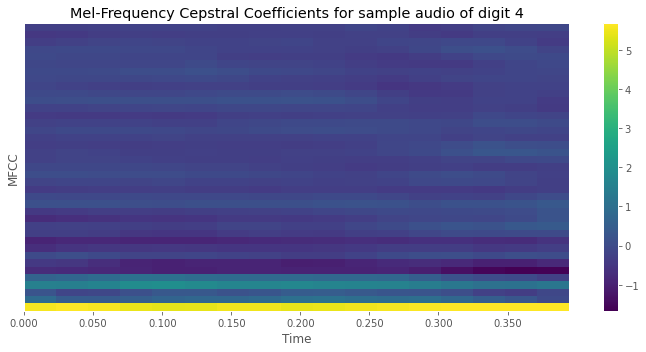

In [8]:
# XX_train 0인덱스에 있는 mfcc 특징값을 matplotlib으로 출력해 확인해 봅니다.
X = mfcc(XX_train[0]).T

# Plot the MFCCs for the digit
plt.figure(figsize=(10, 5))
librosa.display.specshow(X, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title(f'Mel-Frequency Cepstral Coefficients for sample audio of digit {yy_train[0]}')
plt.ylabel('MFCC')
plt.tight_layout()
plt.show()

In [9]:
%%time
mfcc_train, mfcc_val, mfcc_test = mfcc(XX_train), mfcc(XX_val), mfcc(XX_test)
print(f'Number of training recordings: {len(mfcc_train)}')
print(f'Number of validation recordings: {len(mfcc_val)}')
print(f'Number of test recordings: {len(mfcc_test)}')

Number of training recordings: 1160
Number of validation recordings: 400
Number of test recordings: 440
CPU times: user 10.9 s, sys: 24.5 s, total: 35.4 s
Wall time: 5.07 s


In [12]:
clf = seq.KNNClassifier(k=kval, classes=fsdd_labels, weighting='uniform')

In [44]:
clf.fit(mfcc_train, yy_train)

In [45]:
# 검증 결과를 출력해주는 show_results 함수 (정확도 그리고 confusion matrix를 출력)
def show_results(acc, cm, dataset, labels):
    df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True)
    plt.title('Confusion matrix for {} set predictions'.format(dataset), fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()
    print('Accuracy: {:.2f}%'.format(acc * 100))

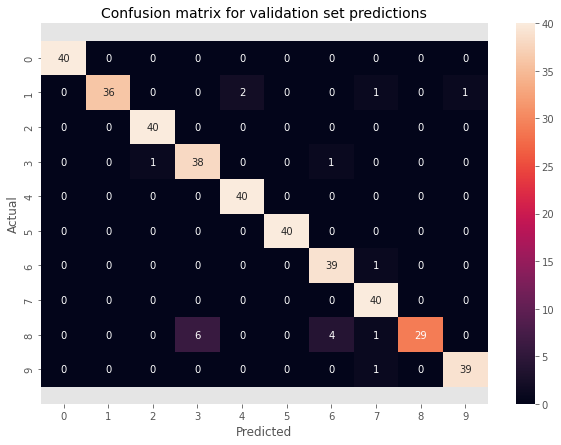

Accuracy: 95.25%


In [46]:
acc, cm = clf.evaluate(mfcc_val, yy_val, verbose=False, n_jobs=-1)

show_results(acc, cm, dataset='validation', labels=fsdd_labels)

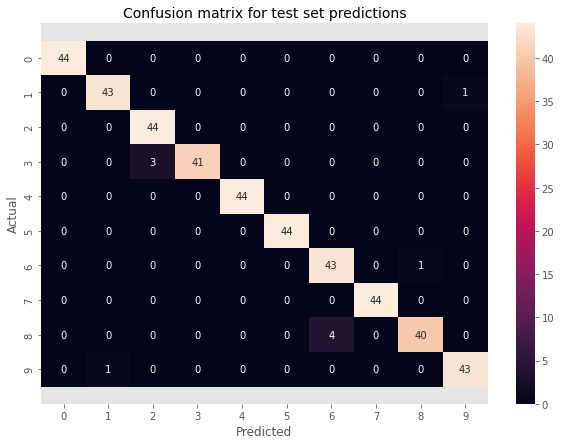

Accuracy: 97.73%


In [38]:
acc, cm = clf.evaluate(mfcc_test, yy_test, verbose=False, n_jobs=-1)
    
show_results(acc, cm, dataset='test', labels=fsdd_labels)